# Prevendo preços de escavadeiras com machine learning

Passos:
1. Definição do problema
2. Definição dos dados
3. Definir métrica de avaliação
4. Definir as features
5. Escolher o modelo
6. Experimentação

## 1. Definição do problema
Dados valores de venda passados, podemos prever por quanto uma escavadeira será vendida?

## 2. Dados
Fonte: Kaggle bluebook bulldozers.
> Train.csv is the training set, which contains data through the end of 2011.

> Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.

> Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Métrica de avaliação
Minimizar o RMSLE (root mean squared log error)


## 4. Features
Data dictionary:
    
    SalesID	  unique identifier of a particular sale of a machine at auction
    MachineID	  identifier for a particular machine;  machines may have multiple sales
    ModelID	  identifier for a unique machine model (i.e. fiModelDesc)
    datasource	  source of the sale record;  some sources are more diligent about reporting attributes of the machine than others.  Note that a particular datasource may report on multiple auctioneerIDs.
    auctioneerID	  identifier of a particular auctioneer, i.e. company that sold the machine at auction.  Not the same as datasource.
    YearMade	  year of manufacturer of the Machine
    MachineHoursCurrentMeter	  current usage of the machine in hours at time of sale (saledate);  null or 0 means no hours have been reported for that sale
    UsageBand	  value (low, medium, high) calculated comparing this particular Machine-Sale hours to average usage for the fiBaseModel;  e.g. 'Low' means this machine has less hours given it's lifespan relative to average of fiBaseModel.
    Saledate	  time of sale
    Saleprice	  cost of sale in USD
    fiModelDesc	  Description of a unique machine model (see ModelID); concatenation of fiBaseModel & fiSecondaryDesc & fiModelSeries & fiModelDescriptor
    fiBaseModel	  disaggregation of fiModelDesc
    fiSecondaryDesc	  disaggregation of fiModelDesc
    fiModelSeries	  disaggregation of fiModelDesc
    fiModelDescriptor	  disaggregation of fiModelDesc
    ProductSize	  Don't know what this is 
    ProductClassDesc	  description of 2nd level hierarchical grouping (below ProductGroup) of fiModelDesc
    State	  US State in which sale occurred
    ProductGroup	  identifier for top-level hierarchical grouping of fiModelDesc
    ProductGroupDesc	  description of top-level hierarchical grouping of fiModelDesc
    Drive_System	machine configuration;  typcially describes whether 2 or 4 wheel drive
    Enclosure	machine configuration - does machine have an enclosed cab or not
    Forks	machine configuration - attachment used for lifting
    Pad_Type	machine configuration - type of treads a crawler machine uses
    Ride_Control	machine configuration - optional feature on loaders to make the ride smoother
    Stick	machine configuration - type of control 
    Transmission	machine configuration - describes type of transmission;  typically automatic or manual
    Turbocharged	machine configuration - engine naturally aspirated or turbocharged
    Blade_Extension	machine configuration - extension of standard blade
    Blade_Width	machine configuration - width of blade
    Enclosure_Type	machine configuration - does machine have an enclosed cab or not
    Engine_Horsepower	machine configuration - engine horsepower rating
    Hydraulics	machine configuration - type of hydraulics
    Pushblock	machine configuration - option
    Ripper	machine configuration - implement attached to machine to till soil
    Scarifier	machine configuration - implement attached to machine to condition soil
    Tip_control	machine configuration - type of blade control
    Tire_Size	machine configuration - size of primary tires
    Coupler	machine configuration - type of implement interface
    Coupler_System	machine configuration - type of implement interface
    Grouser_Tracks	machine configuration - describes ground contact interface
    Hydraulics_Flow	machine configuration - normal or high flow hydraulic system
    Track_Type	machine configuration - type of treads a crawler machine uses
    Undercarriage_Pad_Width	machine configuration - width of crawler treads
    Stick_Length	machine configuration - length of machine digging implement
    Thumb	machine configuration - attachment used for grabbing
    Pattern_Changer	machine configuration - can adjust the operator control configuration to suit the user
    Grouser_Type	machine configuration - type of treads a crawler machine uses
    Backhoe_Mounting	machine configuration - optional interface used to add a backhoe attachment
    Blade_Type	machine configuration - describes type of blade
    Travel_Controls	machine configuration - describes operator control configuration
    Differential_Type	machine configuration - differential type, typically locking or standard
    Steering_Controls	machine configuration - describes operator control configuration


In [1]:
# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modelos
from sklearn.ensemble import RandomForestRegressor
import pickle

# evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [2]:
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False)

In [3]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

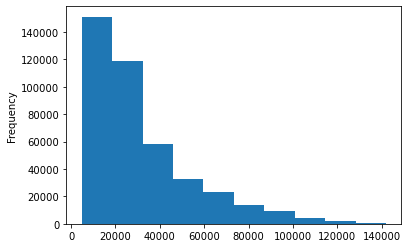

In [4]:
df.SalePrice.plot.hist();

## Parsing dates

In [5]:
df = pd.read_csv("data/TrainAndValid.csv", 
                 low_memory=False, 
                 parse_dates=["saledate"])

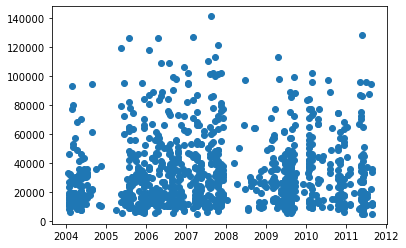

In [6]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [7]:
df.sort_values(by=["saledate"], inplace=True, ascending=True)

## Feature engineering

In [8]:
# fazer uma cópia do DF original
df_tmp = df.copy()

### Adicionar atributos `datetime` para a coluna `saledate`

In [10]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.day_of_week
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.day_of_year

df_tmp.drop("saledate", axis=1, inplace=True)

## Pré-processamento
(model-driven EDA)

In [ ]:
clf = RandomForestRegressor(n_jobs=-1)

X = df_tmp.drop("SalePrice", axis=1)
y = df_tmp["SalePrice"]

clf.fit(X, y)

### Converter strings em categorias

In [19]:
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [21]:
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()
    # agora as categorias tem um valor numérico associado a elas.

### Lidar com valores nulos

In [32]:
df_tmp.isna().sum()/len(df_tmp)  # porcentagem de valores nulos

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

In [34]:
# salvar dados pré-processados
df_tmp.to_csv('data/train_tmp.csv', index=False)

In [35]:
df_tmp = pd.read_csv('data/train_tmp.csv', low_memory=False)

#### Valores numéricos

In [47]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content)\
    and pd.isnull(content).sum():
        print(label)

auctioneerID
MachineHoursCurrentMeter


In [50]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content)\
    and pd.isnull(content).sum():
        # adicionar coluna que diz se o dado era faltante ou não
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # preencher valores com a mediana
        df_tmp[label] = content.fillna(content.median())

#### Valores categóricos

In [52]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [58]:
pd.Categorical(df_tmp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [69]:
# transformar valores categóricos em números e preencher os faltantes
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        df_tmp[label] = pd.Categorical(content).codes + 1
        # +1 porque o default para categoria null é -1

## Criar train, val, test e treinar o modelo

In [75]:
# fazer train e val
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

In [77]:
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

### Definindo função para calcular métrica de avaliação

In [ ]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmslse(y_test, y_preds):
    """
    Calcula o root mean squared log error entre previsões e labels verdadeiras.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Train MAE:": mean_absolute_error(y_train, train_preds):.2f,
              "Valid MAE:": mean_absolute_error(y_valid, val_preds):.2f,
              "Training RMSLE:": rmslse(y_train, train_preds):.2f,
              "Valid RMSLE:": rmslse(y_valid, val_preds):.2f,
              "Training R²": r2_score(y_train, train_preds):.2f,
              "Valid R²": r2_score(y_valid, val_preds):.2f}
    
    return scores

### Reduzir conjunto de dados para fazer experimentos com o modelo

In [91]:
%%time
clf = RandomForestRegressor(n_jobs=-1)
# isso demora muito tempo para rodar
clf.fit(X_train, y_train)
clf.score(X_valid, y_valid)

CPU times: total: 28min 57s
Wall time: 3min 47s


0.8733639609039089

No RandomForest, podemos mudar `max_samples` para diminuir o tamanho do conjunto utilizado.

Outra opção seria fazer `clf.score(X_valid[:50000], y_valid[:10000]))`

In [101]:
%%time
clf = RandomForestRegressor(n_jobs=-1, max_samples=10000)
clf.fit(X_train, y_train)
clf.score(X_valid, y_valid)

CPU times: total: 5min 12s
Wall time: 45.5 s


0.8655894086930488

In [103]:
show_scores(clf)

{'Train MAE:': 4296.612969847304,
 'Valid MAE:': 6373.797323943662,
 'Training RMSLE:': 0.20581375373730093,
 'Valid RMSLE:': 0.26318817103817055,
 'Training R²': 0.9139145258899182,
 'Valid R²': 0.8655894086930488}

## Ajuste de hiperparâmteros

In [110]:
from sklearn.model_selection import RandomizedSearchCV

rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5 , 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

rs_clf = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,),
                           param_distributions=rf_grid,
                           n_iter=2,
                           cv=5,
                           verbose=True)

rs_clf.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1), n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [111]:
show_scores(rs_clf)

{'Train MAE:': 11889.736036240121,
 'Valid MAE:': 14014.741741545147,
 'Training RMSLE:': 0.5132812204601368,
 'Valid RMSLE:': 0.5345739814679863,
 'Training R²': 0.47328269292044167,
 'Valid R²': 0.44524755553201956}

In [113]:
%%time

"""
parâmetros ideais (do curso)
"""
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None)

ideal_model.fit(X_train, y_train)

CPU times: total: 6min 40s
Wall time: 1min 4s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1)

In [114]:
show_scores(ideal_model)

{'Train MAE:': 2950.134633747029,
 'Valid MAE:': 5930.853672541581,
 'Training RMSLE:': 0.1444559444117412,
 'Valid RMSLE:': 0.24543585869527584,
 'Training R²': 0.9590792499642242,
 'Valid R²': 0.8829711062001365}

## Fazer previsões no conjunto de testes

In [140]:
df_test = pd.read_csv('data/Train.csv', 
                      low_memory=False, 
                      parse_dates=["saledate"])

### Preprocessamento dos dados de teste

In [141]:
def preprocess_data(df):
    """
    Pre-processa e transforma um dataframe.
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.day_of_week
    df["saleDayOfYear"] = df.saledate.dt.day_of_year
    df.drop("saledate", axis=1, inplace=True)
    df.drop("SalePrice", axis=1, inplace=True)

    
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content)\
        and pd.isnull(content).sum():
            # adicionar coluna que diz se o dado era faltante ou não
            df[label+"_is_missing"] = pd.isnull(content)
            # preencher valores com a mediana
            df[label] = content.fillna(content.median())

    # transformar valores categóricos em números e preencher os faltantes
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            df[label] = pd.Categorical(content).codes + 1
            # +1 porque o default para categoria null é -1
        
        #ajustar df_test para ter a coluna auctioneerID_is_missing
        df_test["auctioneerID_is_missing"] = False

    return df

### Fazer previsões e formatá-las

In [142]:
df_test = preprocess_data(df_test)
test_preds = ideal_model.predict(df_test)

In [146]:
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds.head()

,SalesID,SalesPrice
0,1139246,62012.162169
1,1139248,50147.051662
2,1139249,11748.870839
3,1139251,32840.363315
4,1139253,12698.550038


In [147]:
df_preds.to_csv("data/test_predictions.csv", index=False)

### Feature importance

In [149]:
ideal_model.feature_importances_[:10]

array([0.03374135, 0.01893898, 0.04688974, 0.00176184, 0.00336251,
       0.19642113, 0.00316105, 0.00105485, 0.03950097, 0.05066652])

In [152]:
def plot_features(columns, importances, n=20):
    df=(pd.DataFrame({"features": columns,
                      "feature_importances": importances})
       .sort_values("feature_importances", ascending=False)
       .reset_index(drop=True))
    
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()

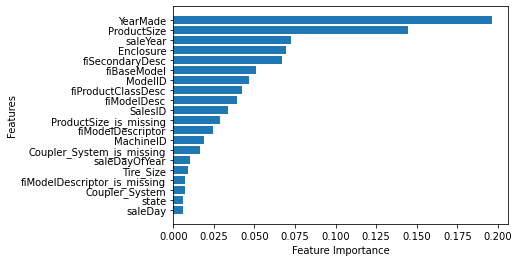

In [153]:
plot_features(X_train.columns, ideal_model.feature_importances_)